# week 10 information theory.

Important Vocab and just general notes.

Digital divide = the divide between people who have access to the internet and those that don't.
Top level domains = .gov, .com, .org, .us, .uk, 
domains used to make it easier to get to websites.

szelogowski life tips always have a vpn. At least using free wifi
lot into edward snowden

In [24]:
print("Hello,world")


Hello,world


In [25]:
import zlib #also izma

text = "here is some text some text text text with repition"
print(f"orginal text {len(text)} bytes:", text)

text_bytes = text.encode('ascii')
comp = zlib.compress(text_bytes)
print(f"compressed text {len(comp)} bytes:", comp)

decomp = zlib.decompress(comp)
print("decompressed text:", decomp.decode('ascii'))

ratio = len(comp) / len(text_bytes)
print(f"compression ration: {ratio:.2f}")


orginal text 51 bytes: here is some text some text text text with repition
compressed text 41 bytes: b'x\x9c\xcbH-JU\xc8,V(\xce\xcfMU(I\xad(Ab!\x88\xf2\xcc\x92\x0c\x85\xa2\xd4\x82\xcc\x92\xcc\xfc<\x00\xebX\x13C'
decompressed text: here is some text some text text text with repition
compression ration: 0.80


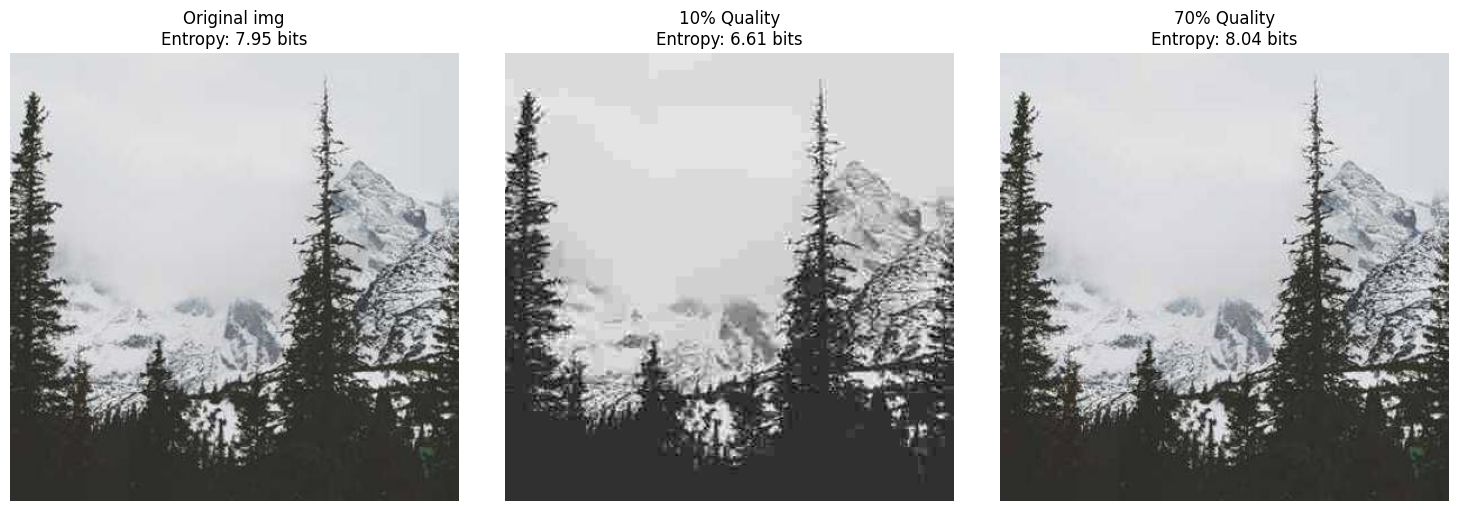

In [26]:
import requests 
import numpy as np 
import matplotlib.pyplot as plt 
from PIL import Image
from io import BytesIO

def entropy(img):
    histogram = img.histogram()
    probs = [float(h)/ sum(histogram) for h in histogram]
    return -sum(p * np.log2(p) for p in probs if p != 0) 

def compress(img, quality=75):
    fname = f'../images/q_{quality}.jpg'
    img.save(fname, 'JPEG', quality=quality)
    compressed = Image.open(fname)
    return compressed, entropy(compressed)

url = 'https://picsum.photos/400/400'
response = requests.get(url)
original = Image.open(BytesIO(response.content))

qualities = [10, 70]
images = [original]
entropies = [entropy(original)]
titles = ['Original img']
for q in qualities:
    img_c, img_h = compress(original, q)
    images.append(img_c)
    entropies.append(img_h)
    titles.append(f'{q}% Quality')

plt.figure(figsize=(15,5))
for lcv, (img, ent, title) in enumerate(zip(images,entropies,titles),start=1):
    plt.subplot(1, len(images), lcv)
    plt.imshow(img)
    plt.title(f"{title}\nEntropy: {ent:.2f} bits")
    plt.axis('off')

plt.tight_layout()
plt.show()


Week 11

In [27]:
%pip install faker tqdm -q
from tqdm import tqdm
from queue import Queue
from faker import Faker
from time import time, sleep



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [28]:
#11/12/2024
class Device:
    def __init__(self,name):
        self.ip = ""
        self.name = name
        self.inbox = Queue()
    
    def send(self, recip, msg):
        print(f"{self.name} is sending {len(msg)} bytes to {recip.ip}")
        for _ in tqdm(range(len(msg)), desc = "Sending", ncols=100):
            sleep(0.25) # ~32 bits/s
        recip.inbox.put(msg.encode('ascii'))

    def receive(self):
        if not self.inbox.empty():
            msg = self.inbox.get().decode('ascii')
            print(f"{self.name} received a message: {msg}")
            return len(msg)
        return 0


In [29]:
class Network:
    def __init__(self):
        self.devices = []
        self.dhcp = Faker()
        self.start_time = time()
        self.usage = 0

    def add_device(self, device:  Device):
        device.ip = self.dhcp.ipv4()
        self.devices.append(device)

    def sim_traffic(self):
        for device in self.devices:
            self.usage += device.receive()

    def display(self):
        print(f"Uptime: {time()- self.start_time:.4} seconds")
        print(f"data Usage: {self.usage} bytes")
        print("Connected devices:")
        for d in self.devices:
            print(f"{d.name}\t\t{d.ip}")

In [30]:
alice = Device("Alice")
bob = Device("Bob")

network = Network()
network.add_device(alice)
network.add_device(bob)

while True:
    sender_name = input("Who are you (Alice/Bob)")
    if sender_name == "Alice":
        sender, recip = alice, bob
    elif sender_name == "Bob":
        sender, recip = bob, alice
    else:
        print("Invalid name")
        continue

    msg = input("Enter your message: ")
    sender.send(recip,msg)
    network.sim_traffic()

    loop = input("Do you want to send another messgae (y/n)")
    if loop not in "yes":
        break
    


network.display()

Alice is sending 5 bytes to 49.62.161.191


Sending: 100%|████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.98it/s]


Bob received a message: hello
Uptime: 7.856 seconds
data Usage: 5 bytes
Connected devices:
Alice		149.181.119.51
Bob		49.62.161.191


# Week 12 - TCP-IP Model

In [31]:
%pip install faker tqdm termcolor -q
import random
from tqdm import tqdm
from time import sleep
from faker import Faker
from termcolor import colored



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [32]:
def print_sleep(msg, seconds=1):
    print(msg)
    sleep(seconds)

def do_progress(length, desc, seconds=0.05):
    for _ in tqdm(range(length), desc=desc, ncols=100):
        sleep(seconds)

In [36]:
class ApplicationLayer:
    def __init__(self, data):
        self.data = data

    def prepare_data(self):
        print_sleep(colored("Application Layer: ", "cyan") + f"preparing data '{self.data}'")
        return self.data.encode()
    
class TransportLayer:
    def __init__(self, protocol="TCP", port=80):
        self.protocol = protocol
        self.port = port
        self.sequence_num = random.randint(1, 1000)

    def prepare_segment(self, data):
        header = colored("Transport Layer: ", "magenta")
        if self.protocol == "TCP":
            print_sleep(header + f"Using TCP on port {self.port} - establish connection ...")
            #TCP HANDSHAKE
            print_sleep(header + f"SYN packet (Seq={self.sequence_num})",0.5)
            print_sleep(header + f"SYN-ACK packet (Seq={self.sequence_num+1})", 0.5)
            print_sleep(header + f"ACK packet - Connection established",0.5)
        else:
            print(header+ f"Using UDP on Port {self.port} - No connection setup required.")

        segment = f"{self.protocol}-Port-{self.port}-Segment-{self.sequence_num}|{data.decode()}"
        do_progress(len(segment), "Transport Layer Processing")
        return segment.encode()

class InternetLayer:
    def __init__(self, src_ip, dest_ip ):
        self.src_ip = src_ip
        self.dest_ip = dest_ip

    def prepare_packet(self, segment):
        print_sleep(colored("Interent layer: ", "yellow")+f"adding IP header(Source; {self.src_ip}, destination: {self.dest_ip}")
        packet = f"IP: {self.src_ip}>{self.dest_ip}|{segment.decode()}"
        do_progress(len(packet), "Internet Layer Processing")
        return packet.encode()
    
class NetworkAccessLayer:
    def __init__(self, src_mac, dest_mac):
        self.src_mac = src_mac
        self.dest_mac = dest_mac

    def prepare_frame(self, packet):
        print_sleep(colored("Network Access Layer: ", "green")+f"adding MAC header (source: {self.src_mac}, Destination: {self.dest_mac})")
        frame = f"MAC:{self.src_mac}>{self.dest_mac}|{packet.decode()}"
        do_progress(len(frame), "network access layer processing")
        return frame.encode()


In [34]:
class InternetDevice:
    def __init__(self,name,ip,mac):
        self.name = name
        self.ip = ip
        self.mac = mac

    def send(self, dest_device, data, port=80):
        app_data = ApplicationLayer(data).prepare_data()
        segment = TransportLayer("TCP").prepare_segment(app_data)
        packet = InternetLayer(self.ip, dest_device.ip).prepare_packet(segment)
        frame = NetworkAccessLayer(self, dest_device.mac).prepare_frame(packet)
        print_sleep(f"\n{self.name} is sending data to {dest_device.name} on port {port}")
        dest_device.receive(frame)

    def receive(self,frame):
        print(f"{self.name} received data:\n{frame.decode()}\n")
        print("Processing data through layers...", 0.1)
        do_progress(5, "network Access layer Decapsulation", 0.1)
        split_frame = frame.decode().split("|")
        del split_frame[0] #Remove MAC header
        do_progress(5, "Network Access Layer Decapsulation", 0.1)
        del split_frame[0] #Remove IP header
        do_progress(5, "network Access Layer Decapsulation", 0.1)
        del split_frame[0] #Remove TCP/UDP header
        do_progress(5, "Network Access Layer Decapsulation", 0.1)
        print(f"\nData received:\n{split_frame[0]}")

In [37]:
router = Faker()
device1 = InternetDevice("computerA", router.ipv4(), router.mac_address())
device2 = InternetDevice("computerB", router.ipv4(), router.mac_address())
device1.send(device2, "hello from ComputerA!", port=80) 

Application Layer: preparing data 'hello from ComputerA!'
Transport Layer: Using TCP on port 80 - establish connection ...
Transport Layer: SYN packet (Seq=265)
Transport Layer: SYN-ACK packet (Seq=266)
Transport Layer: ACK packet - Connection established


Transport Layer Processing: 100%|███████████████████████████████████| 45/45 [00:02<00:00, 19.81it/s]


Interent layer: adding IP header(Source; 136.93.96.240, destination: 211.102.102.210


Internet Layer Processing: 100%|████████████████████████████████████| 79/79 [00:03<00:00, 19.80it/s]


Network Access Layer: adding MAC header (source: <__main__.InternetDevice object at 0x7a10f43c5fa0>, Destination: 14:9a:11:83:5e:d0)


network access layer processing: 100%|████████████████████████████| 152/152 [00:07<00:00, 19.82it/s]



computerA is sending data to computerB on port 80
computerB received data:
MAC:<__main__.InternetDevice object at 0x7a10f43c5fa0>>14:9a:11:83:5e:d0|IP: 136.93.96.240>211.102.102.210|TCP-Port-80-Segment-265|hello from ComputerA!

Processing data through layers... 0.1


Network Access Layer Decapsulation: 100%|█████████████████████████████| 5/5 [00:00<00:00,  9.91it/s]


Data received:
hello from ComputerA!


Week 13 - encryption

In [8]:
%pip install sympy ~q
import sympy

class RSA:
    def __init__(self, p=-1, q=-1):
        p = sympy.randprime(500, 1_000_000) if p == -1 else p
        q = sympy.randprime(500, 1_000_000) if q == -1 else q
        self.n = p * q
        self.phi = (p-1) * (q-1)
        self.e = 2
        while sympy.gcd(self.e, self.phi) != 1:
            self.e += 1
        self.d = pow(self.e, -1, self.phi) # e**-1 % phi
    def encrypt(self, msg):
        cipher = [pow(ord(m), self.e, self.n) for m in msg]
        return cipher

    def decrypt(self, cipher):
        msg = ''.join([chr(pow(c, self.d, self.n)) for c in cipher])
        return msg


ERROR: Invalid requirement: '~q': Expected package name at the start of dependency specifier
    ~q
    ^
Note: you may need to restart the kernel to use updated packages.


In [9]:
import base64
import numpy as np
rsa = RSA(p=61, q=53)
#rsa = RSA()

message = input("Enter a message: ")
print("Entered: ", message)

e_msg = rsa.encrypt(message)
print("Encrypted Message:",e_msg)
print("Encrypted (base64):", base64.b64encode(np.array(e_msg)))

d_msg = rsa.decrypt(e_msg)
print("Decrypted message:",d_msg)

Entered:  im gay
Encrypted Message: [3020, 597, 2774, 728, 1818, 731]
Encrypted (base64): b'zAsAAAAAAABVAgAAAAAAANYKAAAAAAAA2AIAAAAAAAAaBwAAAAAAANsCAAAAAAAA'
Decrypted message: im gay


Week 14 - quantum computing 

In [4]:
%pip install qiskit qiskit-aer -q
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer, AerSimulator
from qiskit.visualization import plot_histogram, plot_bloch_multivector

# Textbook: qiskit.org/learn
# IBM QCsL quantum.ibm.com

Note: you may need to restart the kernel to use updated packages.


Statevector([0.70710678+0.j, 0.70710678+0.j],
            dims=(2,))


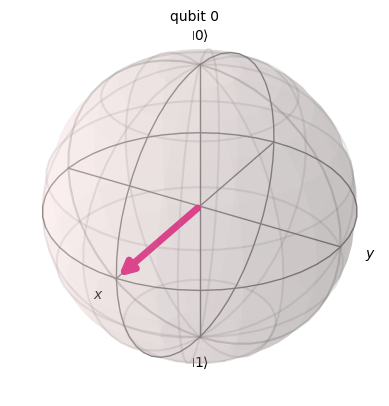

In [5]:
qc = QuantumCircuit(1,1) #1 qubit, 1 classical bit
# The classical bit stores the classical output

# Apply hadamard gate (enter superposition)
qc.h(0)

#visualize on a block sphere 
qc.save_statevector()
sim = AerSimulator()
qobj = transpile(qc,sim)
result = sim.run(qobj).result()
statevector = result.get_statevector()
print(statevector)
plot_bloch_multivector(statevector)

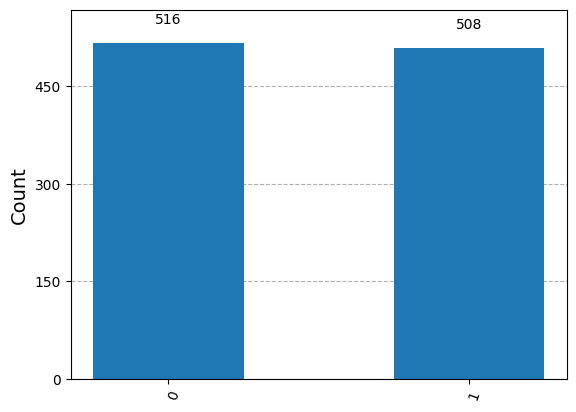

In [6]:
#measure the qubit
qc.measure([0],[0])
#execute 1024 times and get probability distribution
counts=sim.run(qc).result().get_counts()
plot_histogram(counts)


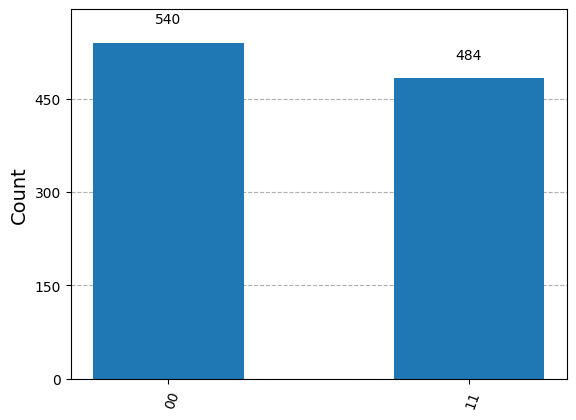

In [9]:
qc_entangle = QuantumCircuit(2,2) # 2 qubits, 2 bits

# create a bell state (entanglement)
qc_entangle.h(0) #superposition
qc_entangle.cx(0,1) # Controlled-not [CNOI] gate (entangle)
qc_entangle.measure([0,1],[0,1])

qc_entangle.save_statevector()
sim_result = sim.run(qc_entangle).result()
counts = sim_result.get_counts()
plot_histogram(counts)



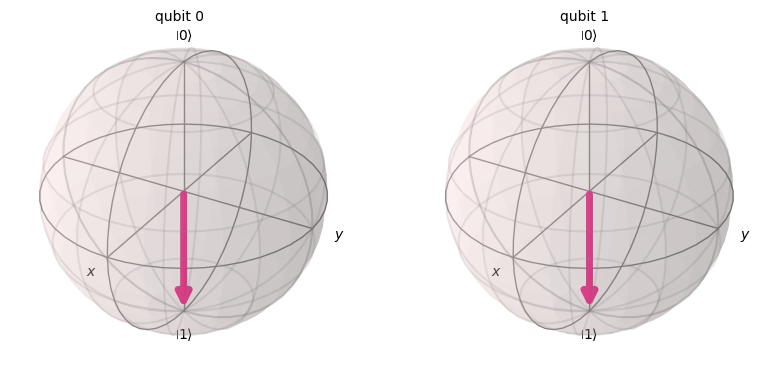

In [10]:
statevectors = sim_result.get_statevector()
plot_bloch_multivector(statevectors)

## Week 21 SQL

In [2]:
import sqlite3
import pandas as pd

conn = sqlite3.connect("prog54a.db")
cur = conn.cursor()
cur.execute("""
CREATE TABLE cars (
            Vehicle TEXT,
            Miles INT,
            Gallons INT,
            MPG FLOAT
)
""")

OperationalError: table cars already exists

In [3]:
data = [
    ('1970 VW Bug',289,9),
    ('1979 Firebird', 412, 40),
    ('1980 Subaru', 361,18),
    ('1975 Cutlass', 161,11)
]
cur.executemany('INSERT INTO cars (Vehicle, Miles, Gallons, MPG) VALUES (?,?,?,0)',data)
conn.commit()

In [4]:
df = pd.read_sql_query('SELECT * FROM cars', conn)
df

,Vehicle,Miles,Gallons,MPG
0,1970 VW Bug,289,9,0.0
1,1979 Firebird,412,40,0.0
2,1980 Subaru,361,18,0.0
3,1975 Cutlass,161,11,0.0


In [5]:
for index, row in df.iterrows():
    mpg = round(row['Miles']/row['Gallons'],1)
    cur.execute('UPDATE cars SET MPG = ? WHERE Vehicle = ?', (mpg,row['Vehicle']))
cur.execute('DELETE FROM cars WHERE MPG < 12 AND Gallons = 40')
conn.commit()

In [6]:
updated_df = pd.read_sql_query('SELECT * FROM cars', conn)
# Close connections to DB
cur.close()
conn.close()
updated_df

,Vehicle,Miles,Gallons,MPG
0,1970 VW Bug,289,9,32.1
1,1980 Subaru,361,18,20.1
2,1975 Cutlass,161,11,14.6


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.barplot(x=df['Miles'], y=df['Vehicle'], pallete ='viridis')
plt.title("Miles drivin in one month per vehicle")
plt.show() 